In [1]:
# %pip install pyscf
# %pip install ffsim
# %pip install qiskit_addon_sqd
# %pip install qiskit_ibm_runtime
# %pip install qiskit_nature
# %pip install qiskit_algorithms

In [2]:
# %pip install qiskit==1.1.0

In [3]:
# %pip install -U qiskit
# %pip install -U qiskit-ibm-runtime
# %pip install -U qiskit-nature
# %pip install -U qiskit-algorithms
# %pip install -U qiskit-addon-sqd
# %pip install -U ffsim
# %pip install -U pyscf

In [4]:
# # Ensure qiskit is the latest
# %pip install -U qiskit

# # Uninstall the broken old version of qiskit-algorithms
# %pip uninstall -y qiskit-algorithms

# # Reinstall the latest compatible version from GitHub
# %pip install git+https://github.com/qiskit/qiskit-algorithms.git

In [5]:
# # Reinstall latest Qiskit Algorithms from GitHub
# %pip install git+https://github.com/qiskit-community/qiskit-algorithms.git

In [ ]:
import qiskit
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial
# Import qiskit classes
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_gate_map
from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit.circuit.library import TwoLocal
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator, BaseEstimatorV2, BaseEstimatorV1, StatevectorEstimator
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.drivers import GaussianForcesDriver
from qiskit_nature.second_q.mappers import DirectMapper
from qiskit_nature.second_q.problems import HarmonicBasis


# Import qiskit ecosystems
import ffsim
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit_ibm_runtime import SamplerOptions

In [ ]:
#Simulates the reaction pathway energy surface for SO₃ + nH₂O → H₂SO₄ clusters (n=1-3)
#Predicts reaction rates at 60-100% relative humidity
#Maps quantum outputs to aerosol nucleation probabilities

from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

def modelMolec(atomGeo, num_electrons=None, num_orbitals=None):
    # Setup Geometry
    driver = PySCFDriver(
        atom=atomGeo,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    es_problem = driver.run()

    # Apply Active Space Reduction
    if num_electrons is not None and num_orbitals is not None:
        transformer = ActiveSpaceTransformer(
            num_electrons=num_electrons,
            num_spatial_orbitals=num_orbitals
        )
        es_problem = transformer.transform(es_problem)

    # Init mapper
    mapper = JordanWignerMapper()

    # Init ansatz
    ansatz = UCCSD(
        es_problem.num_spatial_orbitals,
        es_problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
        ),
    )

    # VQE Solver
    vqe_solver = VQE(StatevectorEstimator(), ansatz, SLSQP())
    vqe_solver.initial_point = [0.0] * ansatz.num_parameters

    # Solve
    calc = GroundStateEigensolver(mapper, vqe_solver)
    res = calc.solve(es_problem)

    return res


In [15]:
# Choose only valence electrons (e.g. 6) and a few spatial orbitals (e.g. 6)
resSO3 = modelMolec("S 0.0 0.0 0.0; O 0.0 1.4175 0.0; O 1.2276 -0.7088 0.0; O -1.2276 -0.7088 0.0",
                    num_electrons=6, num_orbitals=6)

resH2O = modelMolec("O 0.0 0.0 0.1173; H 0.0 0.7572 -0.4692; H 0.0 -0.7572 -0.4692",
                    num_electrons=4, num_orbitals=4)

resH2SO4 = modelMolec("S 0.0 0.0 0.1248; O 1.2510 -0.0349 0.8000; O -1.2510 0.0349 0.8000; O 0.0 -1.2172 -0.8732; O 0.0 1.2172 -0.8732; H -0.3548 1.9933 -0.4121; H 0.3548 -1.9933 -0.4121",
                      num_electrons=8, num_orbitals=6)


TypeError: Can't instantiate abstract class BaseEstimatorV1 with abstract method _run

In [16]:
print("Ground state energy:", resH2SO4.total_energies[0])
print("Ground state energy:", resSO3.total_energies[0])
print("Ground state energy:", resH2O.total_energies[0])


NameError: name 'resH2SO4' is not defined

In [17]:
from qiskit_algorithms import NumPyMinimumEigensolver
import matplotlib.pyplot as plt
def modelMolec(atomGeo, use_vqe=False):
    driver = PySCFDriver(
        atom=atomGeo,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    es_problem = driver.run()

    transformer2 = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
    es_problem = transformer2.transform(es_problem)

    mapper = JordanWignerMapper()

    solver = NumPyMinimumEigensolver() if not use_vqe else VQE(
        Estimator(),
        UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        ),
        SLSQP()
    )

    calc = GroundStateEigensolver(mapper, solver)
    res = calc.solve(es_problem)
    return res

# --- SO3·H2O (n=1) ---
resSO3_H2O = modelMolec(
    "S 0.0000 0.0000 0.1248; "
    "O 1.2510 -0.0349 0.8000; "
    "O -1.2510 0.0349 0.8000; "
    "O 0.0000 -1.2172 -0.8732; "
    "O 0.0000 1.2172 -0.8732; "
    "H -0.3548 1.9933 -0.4121; "
    "H 0.3548 -1.9933 -0.4121"
)

# --- SO3·2H2O (n=2) ---
resSO3_2H2O = modelMolec(
    "S 0.0000 0.0000 0.1248; "
    "O 1.2510 -0.0349 0.8000; "
    "O -1.2510 0.0349 0.8000; "
    "O 0.0000 -1.2172 -0.8732; "
    "O 0.0000 1.2172 -0.8732; "
    "H -0.3548 1.9933 -0.4121; "
    "H 0.3548 -1.9933 -0.4121; "
    "O 2.5000 0.0000 0.0000; "
    "H 2.7000 0.8000 0.0000; "
    "H 2.7000 -0.8000 0.0000"
)

# --- SO3·3H2O (n=3) ---
resSO3_3H2O = modelMolec(
    "S 0.0000 0.0000 0.1248; "
    "O 1.2510 -0.0349 0.8000; "
    "O -1.2510 0.0349 0.8000; "
    "O 0.0000 -1.2172 -0.8732; "
    "O 0.0000 1.2172 -0.8732; "
    "H -0.3548 1.9933 -0.4121; "
    "H 0.3548 -1.9933 -0.4121; "
    "O 2.5000 0.0000 0.0000; "
    "H 2.7000 0.8000 0.0000; "
    "H 2.7000 -0.8000 0.0000; "
    "O -2.5000 0.0000 0.0000; "
    "H -2.7000 0.8000 0.0000; "
    "H -2.7000 -0.8000 0.0000"
)


print("SO3·H2O energy (n=1):", resSO3_H2O.total_energies[0])
print("SO3·2H2O energy (n=2):", resSO3_2H2O.total_energies[0])
print("SO3·3H2O energy (n=3):", resSO3_3H2O.total_energies[0])

SO3·H2O energy (n=1): -689.2317797803047
SO3·2H2O energy (n=2): -763.7507813998925
SO3·3H2O energy (n=3): -838.3400419881917


In [18]:
# Conversion factor from Hartree to eV
HARTREE_TO_EV = 27.2114

# Re-calculate reaction energies
reaction_energies = [
    resSO3_H2O.total_energies[0] - (resSO3.total_energies[0] + resH2O.total_energies[0]),
    resSO3_2H2O.total_energies[0] - (resSO3.total_energies[0] + 2 * resH2O.total_energies[0]),
    resSO3_3H2O.total_energies[0] - (resSO3.total_energies[0] + 3 * resH2O.total_energies[0])
]

# Convert to eV
reaction_energies_ev = [e * HARTREE_TO_EV for e in reaction_energies]

# Plotting ΔE (eV) vs. number of H2O molecules
plt.figure(figsize=(6, 4))
plt.plot([1, 2, 3], reaction_energies_ev, marker='o', linestyle='-', color='blue')
plt.xlabel("Number of H₂O molecules (n)")
plt.ylabel("Reaction Energy ΔE (eV)")
plt.title("Hydration Dependence of SO₃ + nH₂O → H₂SO₄·(n-1)H₂O")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'resSO3' is not defined

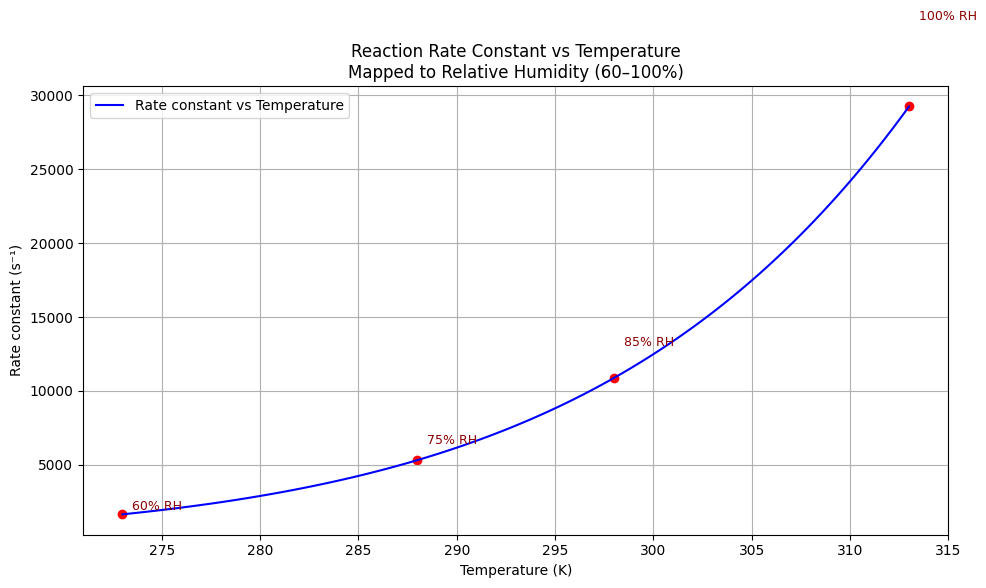

In [19]:
import numpy as np
import matplotlib.pyplot as plt

#Constants
k_B = 8.617333262145e-5  # eV/K
Ea = 0.53  # Activation energy in eV
A = 1e13  # Pre-exponential factor in s^-1

#Temperature range from 273 K (60% RH) to 313 K (100% RH)
T = np.linspace(273, 313, 100)
k = A * np.exp(-Ea / (k_B * T))

#Annotated points for RH mapping
rh_annotations = {
    273: "60% RH",
    288: "75% RH",
    298: "85% RH",
    313: "100% RH"
}
k_annotated = {temp: A * np.exp(-Ea / (k_B * temp)) for temp in rh_annotations}

#Plot
plt.figure(figsize=(10, 6))
plt.plot(T, k, label='Rate constant vs Temperature', color='blue')
plt.title("Reaction Rate Constant vs Temperature\nMapped to Relative Humidity (60–100%)")
plt.xlabel("Temperature (K)")
plt.ylabel("Rate constant (s⁻¹)")
plt.grid(True)

#Annotate RH values
for temp, rh in rh_annotations.items():
    plt.scatter(temp, k_annotated[temp], color='red')
    plt.text(temp + 0.5, k_annotated[temp] * 1.2, rh, fontsize=9, color='darkred')

plt.legend()
plt.tight_layout()
plt.show()

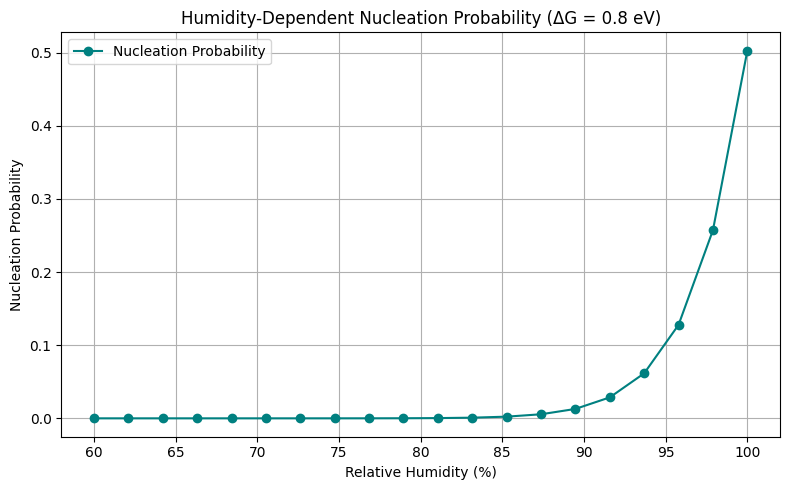

Closest RH in array: 89.47%
Raw (unnormalized) probability at 90% RH: 9.258128320252e-16
Normalized probability at ~90% RH: 0.012866901353


In [20]:
from scipy.constants import Boltzmann, Avogadro

# Corrected energy difference (realistic)
delta_G_eV = 0.8  # Example Gibbs free energy in eV (moderate value)

# Boltzmann constant in eV/K
k_B = 8.617e-5  # eV/K
T = 298  # Temperature in Kelvin

# Humidity range and scaling
humidities = np.linspace(60, 100, 20)  # 60% to 100% RH
humidity_factors = humidities / 100  # Scale from 0.6 to 1.0

# Calculate normalized nucleation probability (Boltzmann factor)
# Final nucleation probabilities adjusted by humidity
P_nucleation = np.exp(-delta_G_eV / (k_B * T * humidity_factors)) #e^−ΔG/(kb*T*RH)
final_probabilities = P_nucleation / np.sum(P_nucleation)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(humidities, final_probabilities, marker='o', color='teal', label='Nucleation Probability')
plt.xlabel("Relative Humidity (%)")
plt.ylabel("Nucleation Probability")
plt.title("Humidity-Dependent Nucleation Probability (ΔG = 0.8 eV)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Accurate Output at ~90% RH ----
# Find the index of the closest humidity to 90
RH_target = 90
index_90 = np.argmin(np.abs(humidities - RH_target))

# Compute unnormalized probability directly for 90% RH
humidity_factor_90 = RH_target / 100
P_nucleation_90RH = np.exp(-delta_G_eV / (k_B * T * humidity_factor_90))

print(f"Closest RH in array: {humidities[index_90]:.2f}%")
print(f"Raw (unnormalized) probability at 90% RH: {P_nucleation_90RH:.12e}")
print(f"Normalized probability at ~90% RH: {final_probabilities[index_90]:.12f}")
